In [1]:
import numpy as np
from scipy.integrate import trapz, cumtrapz
from scipy.interpolate import interpn
import astropy.constants as const
import astropy.units as u

from IPython.display import display, Math

import h5py

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D, HandlerTuple
from matplotlib import ticker
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.image as mpimg
from skimage.measure import marching_cubes, marching_cubes_lewiner
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LightSource
%matplotlib inline
sns.set_context("talk", font_scale=1.2)
sns.set_style('ticks')
sns.set_palette('colorblind')
figparams = {'font.family': 'DejaVu Sans',
             'font.serif':'Times',
             'text.latex.preamble': r'\usepackage{amsmath}',
             'text.usetex': True,
             'hatch.linewidth' : 3.0}
plt.rcParams.update(figparams)
clr = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [3]:
# Global variables
n_samples = int(2 ** 10)
n_mesh = int(2 ** 5)
n_resample = int(2 ** 8)
print(n_samples, n_mesh, n_resample)

label_fsize = 50

1024 32 256


In [4]:
fidhz = 1 / u.yr
coeffs = 4. * const.G ** (5. / 3.) / (3. * np.pi ** (1. / 3.)
                                          * (const.c ** 2)
                                          * (fidhz ** (4. / 3.)))

In [5]:
log_m_min = 7

In [6]:
NANOGrav_hc = 1.9e-15
IPTA_hc = 2.8e-15

# Load data

## AGN-based model

In [7]:
with h5py.File('../data/processed/agn_proxy.h5', 'r') as hf:
    log_m_bh_norm_min = hf['log_m_bh_norm_min'][()]
    log_m_bh_norm_max = hf['log_m_bh_norm_max'][()]
    log_m_bh_range = hf['log_m_bh_range'][:]
    z_range = hf['z_range'][:]
    q_range = hf['q_range'][:]
    differential_bhb_population = hf['population'][:]
    hc = hf['characteristic_strain'][:]
    total_bhmf = hf['total_bhmf'][:]

### Number density

In [8]:
differential_number_density = trapz(trapz(differential_bhb_population[log_m_bh_range >= log_m_bh_norm_min],
                                          log_m_bh_range[log_m_bh_range >= log_m_bh_norm_min], axis=0), q_range, axis=1)
differential_number_density_q = np.quantile(differential_number_density, q=[.16, .5, .84], axis=-1)

In [9]:
local_number_density = differential_number_density_q[:, 0]

order = 10. ** np.floor(np.log10(local_number_density[1]))
display(Math(r'\Phi_{{\rm{{BHB}}, 0}} = ({0:.1f}^{{+{1:.1f}}}_{{-{2:.1f}}}) \times 10^{{{3}}}\;\rm{{Mpc}}^{{-3}}'
             .format(local_number_density[1] / order,
                     (local_number_density[2] - local_number_density[1]) / order,
                     (local_number_density[1] - local_number_density[0]) / order,
                     np.log10(order))))

local_number_density = local_number_density[1]

<IPython.core.display.Math object>

# Analysis

In [10]:
differential_bhb_population = differential_bhb_population[(log_m_bh_range != log_m_bh_norm_min)
                                                          & (log_m_bh_range != log_m_bh_norm_max)]
log_m_bh_range = log_m_bh_range[(log_m_bh_range != log_m_bh_norm_min) & (log_m_bh_range != log_m_bh_norm_max)]

## AGN-based model

In [11]:
mm, zz, qq = np.meshgrid(log_m_bh_range, z_range, q_range, indexing='ij')

In [12]:
hc_integrand = (coeffs * differential_bhb_population * ((10 ** (mm * (5 / 3)))
                                              * (qq / ((1 + qq) ** (1 / 3)))
                                              / ((1 + zz) ** (1 / 3)))[..., np.newaxis]
                * (u.Msun ** (5 / 3)) / (u.Mpc ** 3))

In [13]:
hc_bounds = np.sqrt(cumtrapz(cumtrapz(cumtrapz(hc_integrand[::-1, :, ::-1, :].to(''),
                                               log_m_bh_range[::-1], axis=0, initial=0),
                                      z_range, axis=1, initial=0),
                             q_range[::-1], axis=2, initial=0))

hc_q_bounds = np.quantile(hc_bounds, q=[.16, .5, .84], axis=-1)

In [14]:
z_sat = z_range[hc_q_bounds[1, -1, :, -1] >= 0.95 * hc_q_bounds[1, -1, -1, -1]][0]
# log_m_sat = log_m_bh_range[::-1][(hc_q_bounds[1, :, -1, -1] >= 0.95 * hc_q_bounds[1, -1, -1, -1])][0]
log_m_sat = log_m_bh_range[log_m_bh_range <= 8][-1]

hc_sat = hc_q_bounds[1, -1, -1, -1]

log_m_bh_range_zoom = log_m_bh_range[::-1][1:]
log_m_bh_range_zoom = log_m_bh_range_zoom[log_m_bh_range_zoom >= log_m_sat]

z_range_zoom = z_range[(z_range >= 1) & (z_range <= z_sat)]

In [15]:
log_m_bh_range_zoom

array([9.90322581, 9.80645161, 9.70967742, 9.61290323, 9.51612903,
       9.41935484, 9.32258065, 9.22580645, 9.12903226, 9.03225806,
       8.93548387, 8.83870968, 8.74193548, 8.64516129, 8.5483871 ,
       8.4516129 , 8.35483871, 8.25806452, 8.16129032, 8.06451613,
       7.96774194])

In [16]:
z_sat, log_m_sat

(2.5161290322580645, 7.967741935483871)

### NANOGrav

In [17]:
NANOGrav_n_artificial_range = np.sqrt(np.logspace(-1.5, 1.5, num=n_mesh))

# multiplying factor for the number density used in the lower left panel
NANOGrav_mult_factor = 1.2
NANOGrav_mult_factor_sqrt = np.sqrt(NANOGrav_mult_factor)
NANOGrav_n_artificial_range = np.sort(np.append(NANOGrav_n_artificial_range, NANOGrav_mult_factor_sqrt))

In [18]:
NANOGrav_hc_cube = hc_bounds[:, (z_range >= 1) & (z_range <= z_sat), -1, :]
NANOGrav_hc_cube = NANOGrav_hc_cube[1:, :]
NANOGrav_hc_cube = NANOGrav_hc_cube[log_m_bh_range[::-1][1:] >= log_m_sat, ...]
NANOGrav_hc_cube = np.quantile(NANOGrav_hc_cube, q=.5, axis=-1)
NANOGrav_hc_cube = NANOGrav_hc_cube[..., np.newaxis] * NANOGrav_n_artificial_range[np.newaxis, np.newaxis, :]

NANOGrav_mm_cube = mm[:, (z_range >= 1) & (z_range <= z_sat), -1]
NANOGrav_mm_cube = NANOGrav_mm_cube[::-1, ...]
NANOGrav_mm_cube = NANOGrav_mm_cube[1:, ...]
NANOGrav_mm_cube = NANOGrav_mm_cube[log_m_bh_range[::-1][1:] >= log_m_sat, ...]
NANOGrav_mm_cube = np.repeat(NANOGrav_mm_cube[..., np.newaxis], len(NANOGrav_n_artificial_range), axis=-1)

NANOGrav_zz_cube = zz[:, (z_range >= 1) & (z_range <= z_sat), -1]
NANOGrav_zz_cube = NANOGrav_zz_cube[1:, :]
NANOGrav_zz_cube = NANOGrav_zz_cube[log_m_bh_range[::-1][1:] >= log_m_sat, ...]
NANOGrav_zz_cube = np.repeat(NANOGrav_zz_cube[..., np.newaxis], len(NANOGrav_n_artificial_range), axis=-1)

NANOGrav_nn_cube = local_number_density * (np.broadcast_to(NANOGrav_n_artificial_range[np.newaxis, np.newaxis, ...],
                                                           NANOGrav_hc_cube.shape) ** 2)

In [19]:
# 3D plot data
NANOGrav_log_n_new = np.log10(NANOGrav_mult_factor * local_number_density)
NANOGrav_log_n_range = np.log10(NANOGrav_nn_cube[0, 0, :])

# interpolate the samples to improve the look of the plot a bit
log_m_resample = np.linspace(log_m_bh_range_zoom.max(), log_m_bh_range_zoom.min(), num=n_resample)
z_resample = np.linspace(z_range_zoom.min(), z_range_zoom.max(), num=n_resample)
NANOGrav_log_n_resample = np.linspace(NANOGrav_log_n_range.min(), NANOGrav_log_n_range.max(), num=n_resample)
NANOGrav_log_n_resample = np.sort(np.append(NANOGrav_log_n_resample, NANOGrav_log_n_new))

m_spacing = log_m_resample[0] - log_m_resample[1]
z_spacing = z_resample[1] - z_resample[0]
NANOGrav_n_spacing = NANOGrav_log_n_resample[1] - NANOGrav_log_n_resample[0]

mm_rs, zz_rs, nn_rs = np.meshgrid(log_m_resample, z_resample, NANOGrav_log_n_resample, indexing='ij')
resample_points = np.array([mm_rs.ravel(), zz_rs.ravel(), nn_rs.ravel()]).T

NANOGrav_hc_resample = np.reshape(interpn(points=(log_m_bh_range_zoom[::-1], z_range_zoom, NANOGrav_log_n_range),
                                          values=NANOGrav_hc_cube, xi=resample_points), mm_rs.shape)

In [20]:
NANOGrav_verts, _, _, _ = marching_cubes(NANOGrav_hc_resample, NANOGrav_hc, spacing=(m_spacing, z_spacing, NANOGrav_n_spacing))
NANOGrav_verts[:, 0] += log_m_bh_range_zoom[-1]
NANOGrav_verts[:, 1] += z_range_zoom[0]
NANOGrav_verts[:, 2] += NANOGrav_log_n_range[0]

NANOGrav_cube_top = NANOGrav_hc_resample[..., NANOGrav_log_n_resample >= NANOGrav_log_n_new]
NANOGrav_top_verts, _, _, _ = marching_cubes(NANOGrav_cube_top, NANOGrav_hc, spacing=(m_spacing, z_spacing, NANOGrav_n_spacing))
NANOGrav_top_verts[:, 0] += log_m_bh_range_zoom[-1]
NANOGrav_top_verts[:, 1] += z_range_zoom[0]
NANOGrav_top_verts[:, 2] -= NANOGrav_top_verts[:, 2].max() - NANOGrav_verts[:, 2].max()

NANOGrav_cube_bottom = NANOGrav_hc_resample[..., NANOGrav_log_n_resample <= NANOGrav_log_n_new]
if NANOGrav_cube_bottom.max() >= NANOGrav_hc:
    NANOGrav_bottom_verts, _, _, _ = marching_cubes(NANOGrav_cube_bottom, NANOGrav_hc, spacing=(m_spacing, z_spacing, NANOGrav_n_spacing))
    NANOGrav_bottom_verts[:, 0] += log_m_bh_range_zoom[-1]
    NANOGrav_bottom_verts[:, 1] += z_range_zoom[0]
    NANOGrav_bottom_verts[:, 2] += NANOGrav_log_n_range[0]
else:
    NANOGrav_bottom_verts = None

NANOGrav_xx_3d, NANOGrav_yy_3d = np.meshgrid(log_m_bh_range_zoom, z_range_zoom)
NANOGrav_zz_3d = NANOGrav_log_n_new * np.ones_like(NANOGrav_xx_3d)

In [21]:
NANOGrav_cube_bottom.max()

1.9420475067255253e-15

### IPTA

In [22]:
IPTA_n_artificial_range = np.sqrt(np.logspace(-1.5, 1.5, num=n_mesh))
IPTA_mult_factor = 1.25 * ((IPTA_hc / hc_sat) ** 2)
IPTA_mult_factor_sqrt = np.sqrt(IPTA_mult_factor)
IPTA_n_artificial_range = np.sort(np.append(IPTA_n_artificial_range, IPTA_mult_factor_sqrt))
IPTA_mult_factor

2.6890778038634098

In [23]:
IPTA_hc_cube = hc_bounds[:, (z_range >= 1) & (z_range <= z_sat), -1, :]
IPTA_hc_cube = IPTA_hc_cube[1:, :]
IPTA_hc_cube = IPTA_hc_cube[log_m_bh_range[::-1][1:] >= log_m_sat, ...]
IPTA_hc_cube = np.quantile(IPTA_hc_cube, q=.5, axis=-1)
IPTA_hc_cube = IPTA_hc_cube[..., np.newaxis] * IPTA_n_artificial_range[np.newaxis, np.newaxis, :]

IPTA_mm_cube = mm[:, (z_range >= 1) & (z_range <= z_sat), -1]
IPTA_mm_cube = IPTA_mm_cube[::-1, ...]
IPTA_mm_cube = IPTA_mm_cube[1:, ...]
IPTA_mm_cube = IPTA_mm_cube[log_m_bh_range[::-1][1:] >= log_m_sat, ...]
IPTA_mm_cube = np.repeat(IPTA_mm_cube[..., np.newaxis], len(IPTA_n_artificial_range), axis=-1)

IPTA_zz_cube = zz[:, (z_range >= 1) & (z_range <= z_sat), -1]
IPTA_zz_cube = IPTA_zz_cube[1:, :]
IPTA_zz_cube = IPTA_zz_cube[log_m_bh_range[::-1][1:] >= log_m_sat, ...]
IPTA_zz_cube = np.repeat(IPTA_zz_cube[..., np.newaxis], len(IPTA_n_artificial_range), axis=-1)

IPTA_nn_cube = local_number_density * (np.broadcast_to(IPTA_n_artificial_range[np.newaxis, np.newaxis, ...],
                                                       IPTA_hc_cube.shape) ** 2)

In [24]:
# 3D plot data
IPTA_log_n_new = np.log10(IPTA_mult_factor * local_number_density)
IPTA_log_n_range = np.log10(IPTA_nn_cube[0, 0, :])

# interpolate the samples to improve the look of the plot a bit
log_m_resample = np.linspace(log_m_bh_range_zoom.max(), log_m_bh_range_zoom.min(), num=n_resample)
z_resample = np.linspace(z_range_zoom.min(), z_range_zoom.max(), num=n_resample)
IPTA_log_n_resample = np.linspace(IPTA_log_n_range.min(), IPTA_log_n_range.max(), num=n_resample)
IPTA_log_n_resample = np.sort(np.append(IPTA_log_n_resample, IPTA_log_n_new))

m_spacing = log_m_resample[0] - log_m_resample[1]
z_spacing = z_resample[1] - z_resample[0]
IPTA_n_spacing = IPTA_log_n_resample[1] - IPTA_log_n_resample[0]

mm_rs, zz_rs, nn_rs = np.meshgrid(log_m_resample, z_resample, IPTA_log_n_resample, indexing='ij')
resample_points = np.array([mm_rs.ravel(), zz_rs.ravel(), nn_rs.ravel()]).T

IPTA_hc_resample = np.reshape(interpn(points=(log_m_bh_range_zoom[::-1], z_range_zoom, IPTA_log_n_range),
                                          values=IPTA_hc_cube, xi=resample_points), mm_rs.shape)

In [25]:
IPTA_verts, _, _, _ = marching_cubes(IPTA_hc_resample, IPTA_hc, spacing=(m_spacing, z_spacing, IPTA_n_spacing))
IPTA_verts[:, 0] += log_m_bh_range_zoom[-1]
IPTA_verts[:, 1] += z_range_zoom[0]
IPTA_verts[:, 2] += IPTA_log_n_range[0]

IPTA_cube_top = IPTA_hc_resample[..., IPTA_log_n_resample >= IPTA_log_n_new]
IPTA_top_verts, _, _, _ = marching_cubes(IPTA_cube_top, IPTA_hc, spacing=(m_spacing, z_spacing, IPTA_n_spacing))
IPTA_top_verts[:, 0] += log_m_bh_range_zoom[-1]
IPTA_top_verts[:, 1] += z_range_zoom[0]
IPTA_top_verts[:, 2] -= IPTA_top_verts[:, 2].max() - IPTA_verts[:, 2].max()

IPTA_cube_bottom = IPTA_hc_resample[..., IPTA_log_n_resample <= IPTA_log_n_new]
if IPTA_cube_bottom.max() >= IPTA_hc:
    IPTA_bottom_verts, _, _, _ = marching_cubes(IPTA_cube_bottom, IPTA_hc, spacing=(m_spacing, z_spacing, IPTA_n_spacing))
    IPTA_bottom_verts[:, 0] += log_m_bh_range_zoom[-1]
    IPTA_bottom_verts[:, 1] += z_range_zoom[0]
    IPTA_bottom_verts[:, 2] += IPTA_log_n_range[0]
else:
    IPTA_bottom_verts = None

IPTA_xx_3d, IPTA_yy_3d = np.meshgrid(log_m_bh_range_zoom, z_range_zoom)
IPTA_zz_3d = IPTA_log_n_new * np.ones_like(IPTA_xx_3d)

# Plots

In [26]:
w_pad = 1.08 / 2

## AGN-based model

### NANOGrav

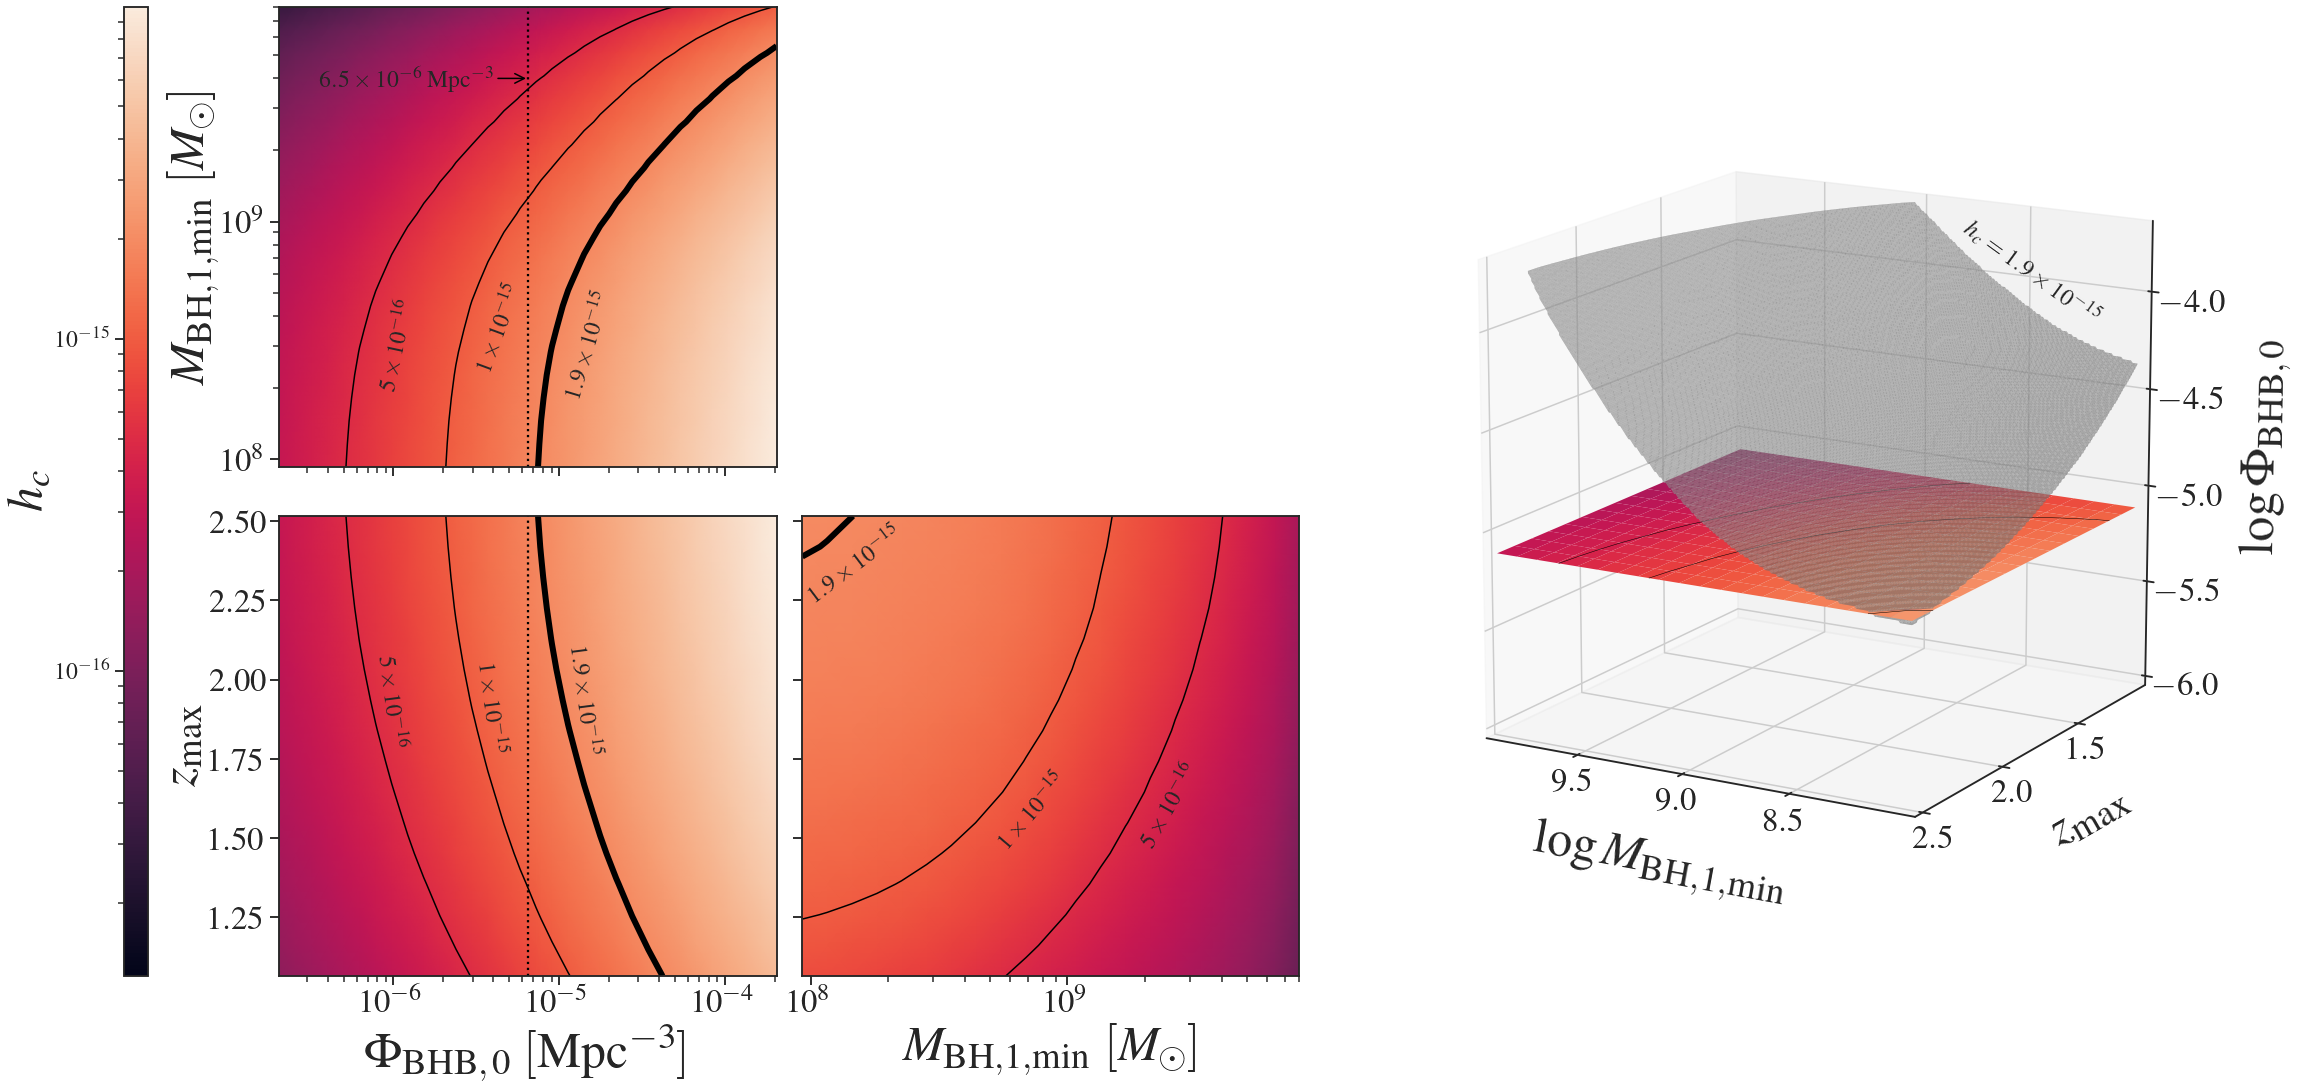

In [27]:
# corner plots
# %matplotlib inline
fmt = {}
strs = [r'$5 \times 10^{{-16}}$', r'$1 \times 10^{{-15}}$', r'$1.9 \times 10^{{-15}}$']
levels = [5e-16, 1e-15, NANOGrav_hc]
linewidths = [1.5, 1.5, 6]
labels = dict(zip(levels, strs))
cfont_size = 32
inline_spacing=1
inline=False
n_art_idx = 21
text_fs = 24

# NANOGrav_plot_3d = mpimg.imread('../reports/figures/NANOGrav_3D.png')
light = LightSource(-60, 15)

sns.set_context("talk", font_scale=2)

widths = [.05, 1, 1, 2]
heights = [1, 1]

order = 10. ** np.floor(NANOGrav_log_n_new)
art_dens = r'${0:.1f} \times 10^{{{1:.0f}}} \; \rm{{Mpc}}^{{-3}}$'.format((10 ** NANOGrav_log_n_new) / order, np.log10(order))
order = 10. ** np.floor(np.log10(local_number_density))
est_dens = r'${0:.1f} \times 10^{{{1:.0f}}} \; \rm{{Mpc}}^{{-3}}$'.format(local_number_density / order, np.log10(order))

fig_width = 30
fig_height = fig_width * np.sum(heights) / (np.sum(widths) + .1)

fig = plt.figure(figsize=(32, 15), constrained_layout=True)
gs = fig.add_gridspec(nrows=2, ncols=4, width_ratios=widths, height_ratios=heights)

cnorm = colors.LogNorm(vmin=np.amin(NANOGrav_hc_cube),
                       vmax=np.amax(NANOGrav_hc_cube))
cmap = sns.color_palette("rocket", as_cmap=True)
c = cmap(cnorm(np.squeeze(NANOGrav_hc_cube[log_m_bh_range_zoom == log_m_sat, :, :])))

# next the slices from 3D parameter space
mm_nn_ax = fig.add_subplot(gs[0, 1])
pcm = mm_nn_ax.pcolormesh(np.squeeze(NANOGrav_nn_cube[:, z_range_zoom == z_sat, :]),
                          10 ** np.squeeze(NANOGrav_mm_cube[:, z_range_zoom == z_sat, :]),
                          np.squeeze(NANOGrav_hc_cube[:, z_range_zoom == z_sat, :]), norm=cnorm,
                          shading='gouraud')
cs = mm_nn_ax.contour(np.squeeze(NANOGrav_nn_cube[:, z_range_zoom == z_sat, :]),
                       np.squeeze(10 ** NANOGrav_mm_cube[:, z_range_zoom == z_sat, :]),
                       np.squeeze(NANOGrav_hc_cube[:, z_range_zoom == z_sat, :]), levels=levels,
                       locator=ticker.LogLocator(), colors='black',
                       linewidths=linewidths)

# custom contours
# for i, (cl, lbl) in enumerate(zip(cs.collections, strs)):
p = cs.collections[0].get_paths()[0]
v = p.vertices
x = v[:, 0]
y = v[:, 1]

mid = int(np.trunc(len(x) / 2)) - 10
rot = np.degrees(np.arctan2([np.log10(y[mid - 4]) - np.log10(y[mid - 10])], [np.log10(x[mid - 4]) - np.log10(x[mid - 10])]))[0]
mm_nn_ax.text(x[mid + 2], y[mid - 5], strs[0], rotation=rot,
              verticalalignment='baseline', horizontalalignment='center', rotation_mode='anchor', fontsize=text_fs)

p = cs.collections[1].get_paths()[0]
v = p.vertices
x = v[:, 0]
y = v[:, 1]

mid = int(np.trunc(len(x) / 2)) - 9
rot = np.degrees(np.arctan2([np.log10(y[mid - 4]) - np.log10(y[mid - 6])], [np.log10(x[mid - 4]) - np.log10(x[mid - 6])]))[0]
mm_nn_ax.text(x[mid + 2], y[mid - 5], strs[1], rotation=rot,
              verticalalignment='baseline', horizontalalignment='center', rotation_mode='anchor', fontsize=text_fs)

p = cs.collections[2].get_paths()[0]
v = p.vertices
x = v[:, 0]
y = v[:, 1]

mid = int(np.trunc(len(x) / 2)) - 5
rot = np.degrees(np.arctan2([np.log10(y[mid - 2]) - np.log10(y[mid - 10])], [np.log10(x[mid - 2]) - np.log10(x[mid - 10])]))[0]
mm_nn_ax.text(x[mid + 2], y[mid - 5], strs[2], rotation=rot,
              verticalalignment='baseline', horizontalalignment='center', rotation_mode='anchor', fontsize=text_fs)

mm_nn_ax.axvline(local_number_density, color='k', linestyle=':')
mm_nn_ax.annotate(est_dens,
                  xy=(local_number_density, 4e9), xycoords='data',
                  xytext=(4e-6, 4e9), textcoords='data', 
                  fontsize=text_fs, arrowprops=dict(arrowstyle="->", linestyle='-', color='k', connectionstyle="arc3",
                                                    relpos=(1,.5)), rotation_mode='anchor', ha='right', va='center')

mm_nn_ax.set_ylabel(r'$M_{\rm{BH}, 1, \min}\ [M_{\odot}]$', fontsize=label_fsize)
mm_nn_ax.set_yscale('log')
mm_nn_ax.set_xscale('log')
plt.setp(mm_nn_ax.get_xticklabels(), visible=False)

zz_nn_ax = fig.add_subplot(gs[1, 1], sharex=mm_nn_ax)
pcm = zz_nn_ax.pcolormesh(np.squeeze(NANOGrav_nn_cube[log_m_bh_range_zoom == log_m_sat, :, :]),
                          np.squeeze(NANOGrav_zz_cube[log_m_bh_range_zoom == log_m_sat, :, :]),
                          np.squeeze(NANOGrav_hc_cube[log_m_bh_range_zoom == log_m_sat, :, :]), norm=cnorm,
                          shading='gouraud')
cs = zz_nn_ax.contour(np.squeeze(NANOGrav_nn_cube[log_m_bh_range_zoom == log_m_sat, :, :]),
                       np.squeeze(NANOGrav_zz_cube[log_m_bh_range_zoom == log_m_sat, :, :]),
                       np.squeeze(NANOGrav_hc_cube[log_m_bh_range_zoom == log_m_sat, :, :]), levels=levels,
                       locator=ticker.LogLocator(), colors='black',
                       linewidths=linewidths)

# custom contours
for cl, lbl in zip(cs.collections, strs):
    p = cl.get_paths()[0]
    v = p.vertices
    x = v[:, 0]
    y = v[:, 1]
    
    mid = int(np.trunc(len(x) / 2))
    
    rot = np.degrees(np.arctan2([y[-1] - y[0]], [np.log10(x[-1]) - np.log10(x[0])]))[0] - 20
    
    zz_nn_ax.text(x[mid + 2], y[mid - 4], lbl, rotation=rot,
                  verticalalignment='top', horizontalalignment='center', rotation_mode='anchor', fontsize=text_fs)
    
zz_nn_ax.axvline(local_number_density, color='k', linestyle=':')
# zz_nn_ax.text(local_number_density, np.min(z_range_zoom) + .01, est_dens, rotation='vertical',
#               horizontalalignment='left', verticalalignment='bottom', rotation_mode='anchor', fontsize=text_fs)
zz_nn_ax.set_xlabel(r'$\Phi_{\rm{BHB},\,0}\ [\rm{Mpc}^{-3}]$', fontsize=label_fsize)
zz_nn_ax.set_xscale('log')
zz_nn_ax.set_ylabel(r'$z_{\rm{max}}$', fontsize=label_fsize)

zz_mm_ax = fig.add_subplot(gs[1, 2], sharey=zz_nn_ax)
pcm = zz_mm_ax.pcolormesh(10 ** np.squeeze(NANOGrav_mm_cube[:, :, NANOGrav_n_artificial_range == NANOGrav_mult_factor_sqrt]),
                          np.squeeze(NANOGrav_zz_cube[:, :, NANOGrav_n_artificial_range == NANOGrav_mult_factor_sqrt]),
                          np.squeeze(NANOGrav_hc_cube[:, :, NANOGrav_n_artificial_range == NANOGrav_mult_factor_sqrt]),
                          norm=cnorm, shading='gouraud')
cs = zz_mm_ax.contour(10 ** np.squeeze(NANOGrav_mm_cube[:, :, NANOGrav_n_artificial_range == NANOGrav_mult_factor_sqrt]),
                       np.squeeze(NANOGrav_zz_cube[:, :, NANOGrav_n_artificial_range == NANOGrav_mult_factor_sqrt]),
                       np.squeeze(NANOGrav_hc_cube[:, :, NANOGrav_n_artificial_range == NANOGrav_mult_factor_sqrt]), levels=levels,
                       locator=ticker.LogLocator(), colors='black',
                       linewidths=linewidths)

# custom contours
for i, (cl, lbl) in enumerate(zip(cs.collections, strs)):
    p = cl.get_paths()[0]
    v = p.vertices
    x = v[:, 0]
    y = v[:, 1]
    
    mid = int(np.trunc(len(x) / 2))
    
    rot = np.degrees(np.arctan2([y[mid + 1] - y[mid - 1]], [np.log10(x[mid + 1]) - np.log10(x[mid - 1])]))[0]
    
    zz_mm_ax.text(x[mid + 1] - 5e6, y[mid - 1] - .025, lbl, rotation=rot,
                  verticalalignment='top', horizontalalignment='center', rotation_mode='anchor', fontsize=text_fs)
#     if i == 1:
#         break

zz_mm_ax.set_xlabel(r'$M_{\rm{BH}, 1, \min}\ [M_{\odot}]$', fontsize=label_fsize)
zz_mm_ax.set_ylabel(r'$ $', fontsize=label_fsize)
zz_mm_ax.set_xscale('log')
plt.setp(zz_mm_ax.get_yticklabels(), visible=False)

# add a colorbar
cb_ax = fig.add_subplot(gs[:, 0])
cb = plt.colorbar(pcm, cax=cb_ax)
cb.set_label(r'$h_{c}$', fontsize=label_fsize)
cb_ax.tick_params(labelsize=text_fs) 

cb_ax.yaxis.set_ticks_position('left')
cb_ax.yaxis.set_label_position('left')

# # add Mathematica plot
# plot_3d_ax = fig.add_subplot(gs[:, 3])
# plot_3d_ax.imshow(NANOGrav_plot_3d)
# plot_3d_ax.axis('off')

# add 3D plot
plot_3d_ax = fig.add_subplot(gs[:, 3], projection='3d')
if NANOGrav_bottom_verts is not None:
    tri_bottom = plot_3d_ax.plot_trisurf(NANOGrav_bottom_verts[:, 0], NANOGrav_bottom_verts[:,1], NANOGrav_bottom_verts[:, 2], #vmin=-4,
                                         lw=0, color=clr[7], shade=True, lightsource=light, alpha=.8)
tri_top = plot_3d_ax.plot_trisurf(NANOGrav_top_verts[:, 0], NANOGrav_top_verts[:,1], NANOGrav_top_verts[:, 2], #vmin=-4,
                                  lw=0, color=clr[7], shade=True, lightsource=light, alpha=.8)
surf = plot_3d_ax.plot_surface(NANOGrav_xx_3d, NANOGrav_yy_3d, NANOGrav_zz_3d, shade=False, lightsource=light, 
                               facecolors=c, alpha=1, lw=0)
if NANOGrav_bottom_verts is not None:
    tri_bottom.set_sort_zpos(.5)

surf.set_sort_zpos(1.5)
tri_top.set_sort_zpos(2.5)

# custom contours
for i, cl in enumerate(cs.collections):
    p = cl.get_paths()[0]
    v = p.vertices
    x = v[:, 0]
    y = v[:, 1]
    
#     print(np.log10(x))
#     print(np.log10(NANOGrav_mult_factor * local_number_density))
    lw = .5
    plot_3d_ax.plot(np.log10(x), y, NANOGrav_log_n_new, color='k', zorder=3, linewidth=lw)
#     if i == 1:
#         break

plot_3d_ax.set_xlim(log_m_bh_range_zoom[0], log_m_bh_range_zoom[-1])
plot_3d_ax.set_ylim(z_range_zoom[-1], z_range_zoom[0])
# plot_3d_ax.set_zlim(log_n_range[0], log_n_range[-1])
# plot_3d_ax.text(np.max(NANOGrav_xx_3d), np.max(NANOGrav_yy_3d), NANOGrav_zz_3d[0, 0] - .05,
#                 r'$\Phi_{\rm{BHB},\,0} = $' + art_dens,
#                 zdir='x', rotation_mode='anchor', verticalalignment='top',
#                 fontsize=text_fs, zorder=5)

density_label_x = NANOGrav_top_verts[NANOGrav_top_verts[:, 1] == NANOGrav_top_verts[:, 1].min(), 0].max()
density_label_y = NANOGrav_top_verts[NANOGrav_top_verts[:, 1] == NANOGrav_top_verts[:, 1].min(), 1][0]
density_label_z = NANOGrav_top_verts[NANOGrav_top_verts[:, 1] == NANOGrav_top_verts[:, 1].min(), 2].max()
delta_x = density_label_x - NANOGrav_top_verts[NANOGrav_top_verts[:, 1] == NANOGrav_top_verts[:, 1].min(), 0].min()
delta_z = density_label_z - NANOGrav_top_verts[NANOGrav_top_verts[:, 1] == NANOGrav_top_verts[:, 1].min(), 2].min()
plot_3d_ax.text(density_label_x - (.5 * delta_x), density_label_y, density_label_z - (.5 * delta_z),
                r'$h_{c} = 1.9 \times 10^{-15}$',
                zdir=(delta_x, 0, delta_z), rotation_mode='anchor', 
                horizontalalignment='center', verticalalignment='bottom',
                fontsize=text_fs, zorder=5)
plot_3d_ax.set_zlim(-6, NANOGrav_log_n_range[-1])
plot_3d_ax.set_xticks([8.5, 9, 9.5])
plot_3d_ax.set_yticks([1.5, 2, 2.5])
plot_3d_ax.set_zticks([-6, -5.5, -5, -4.5, -4])
plot_3d_ax.tick_params(axis='z', which='major', pad=25)
plot_3d_ax.view_init(azim=-60, elev=15)
plot_3d_ax.set_xlabel(r'$\log M_{\rm{BH}, 1, \min}$', fontsize=label_fsize, labelpad=50)
plot_3d_ax.set_ylabel(r'$z_{\rm{max}}$', fontsize=label_fsize, labelpad=40)
plot_3d_ax.set_zlabel(r'$\log \Phi_{\rm{BHB},\,0}$', fontsize=label_fsize, labelpad=70)
plot_3d_ax.set_box_aspect(aspect=(4,4,4), zoom=1.1)
plot_3d_ax.dist = 13
plot_3d_ax.set_rasterized(True)

# plt.tight_layout(w_pad=w_pad)
plt.savefig('../reports/figures/corner_NANOGrav.pdf')
plt.savefig('../reports/figures/corner_NANOGrav.png')
plt.show()

### IPTA

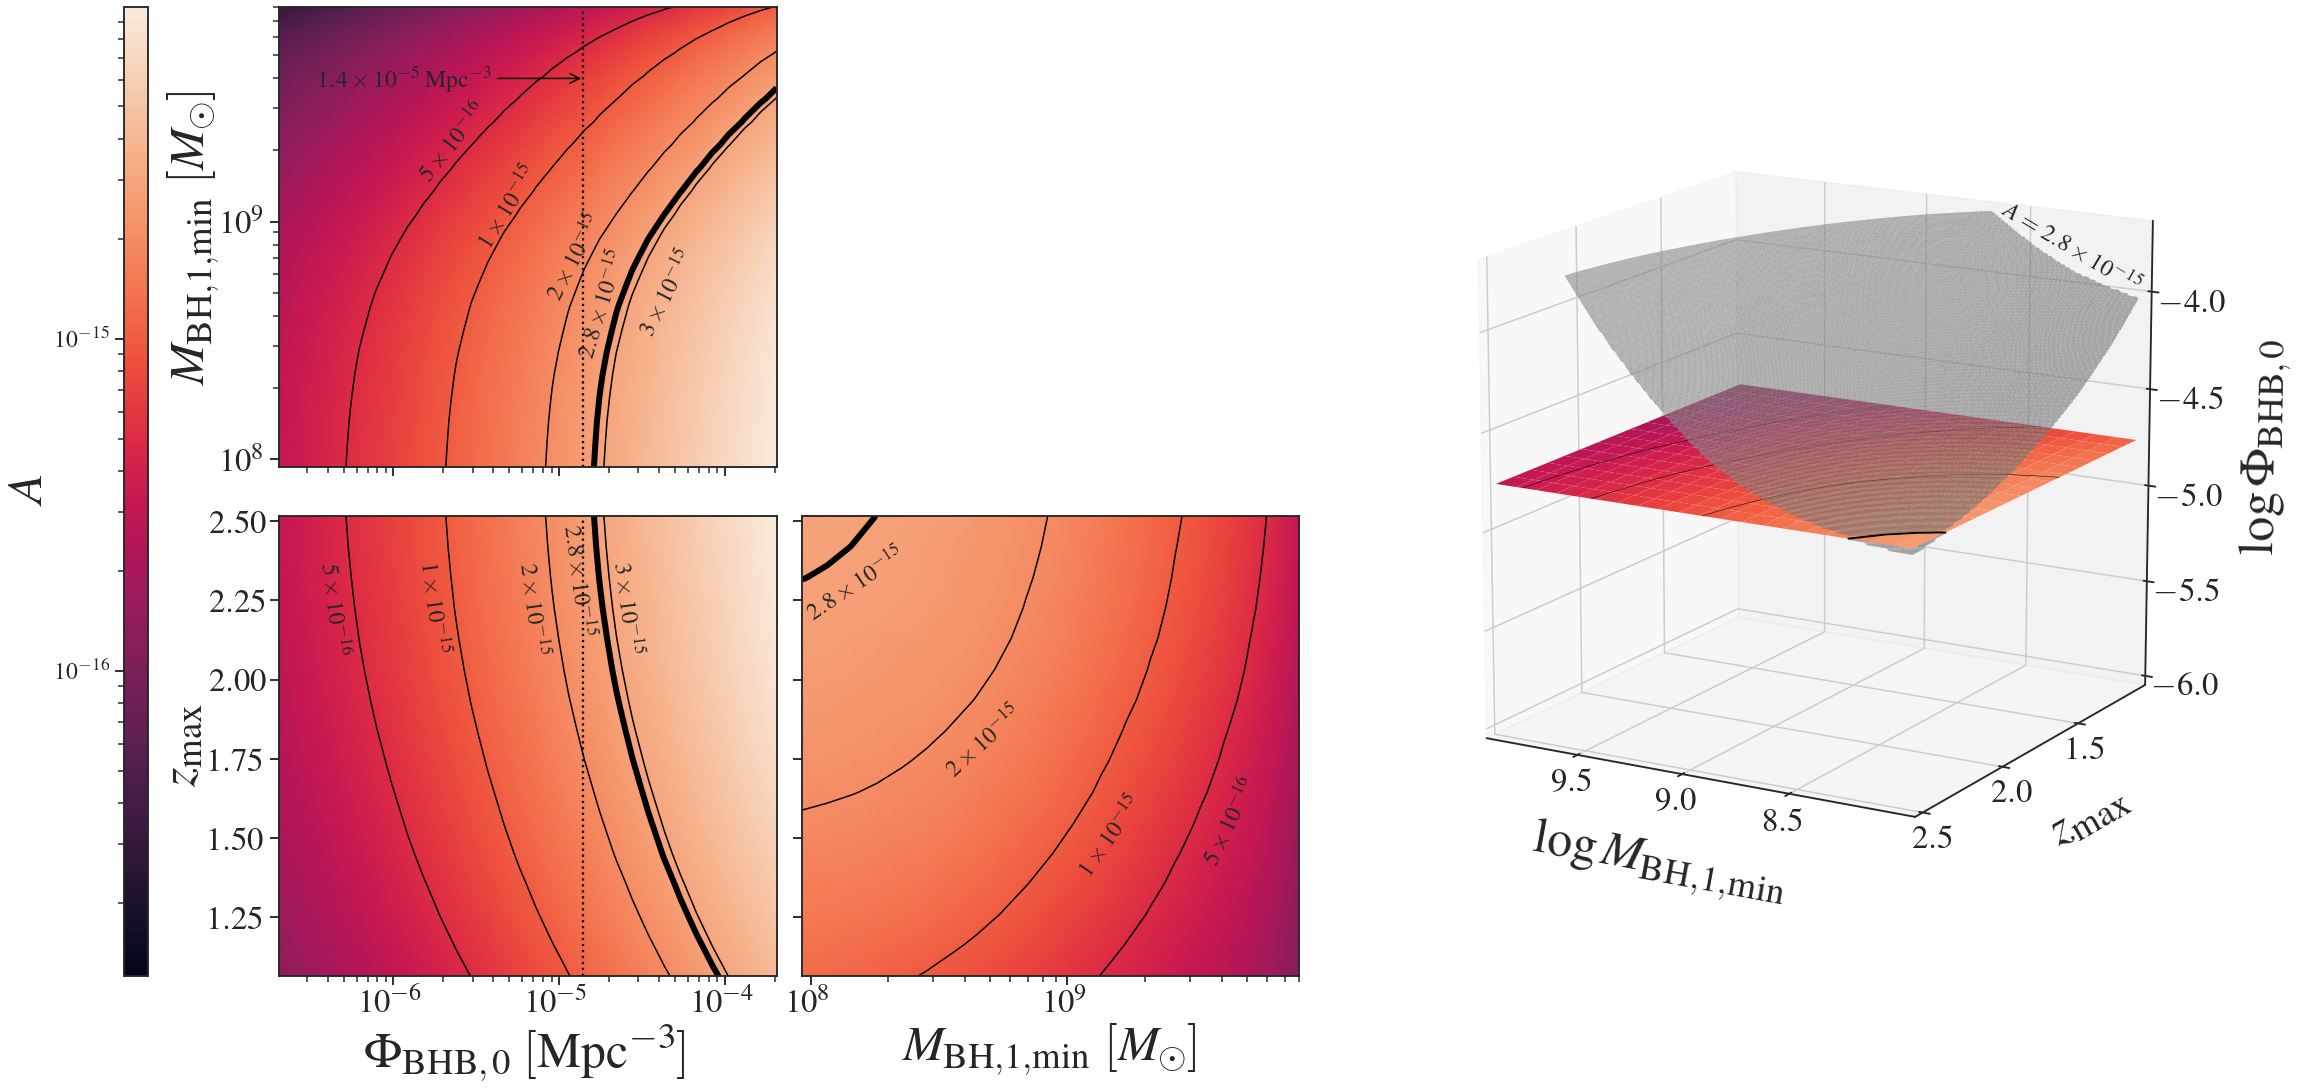

In [28]:
# corner plots
# %matplotlib inline
fmt = {}
strs = [r'$5 \times 10^{{-16}}$', r'$1 \times 10^{{-15}}$', r'$2 \times 10^{{-15}}$', r'$2.8 \times 10^{{-15}}$', r'$3 \times 10^{{-15}}$']
levels = [5e-16, 1e-15, 2e-15, IPTA_hc, 3e-15]
linewidths = [1.5, 1.5, 1.5, 6, 1.5]
labels = dict(zip(levels, strs))
cfont_size = 32
inline_spacing=1
inline=False
n_art_idx = 21
text_fs = 24

sns.set_context("talk", font_scale=2)

widths = [.05, 1, 1, 2]
heights = [1, 1]

order = 10. ** np.floor(IPTA_log_n_new)
art_dens = r'${0:.1f} \times 10^{{{1:.0f}}} \; \rm{{Mpc}}^{{-3}}$'.format((10 ** IPTA_log_n_new) / order, np.log10(order))
order = 10. ** np.floor(np.log10(local_number_density * IPTA_mult_factor / 1.25))
est_dens = r'${0:.1f} \times 10^{{{1:.0f}}} \; \rm{{Mpc}}^{{-3}}$'.format((local_number_density * IPTA_mult_factor / 1.25)
                                                                          / order, np.log10(order))

fig_width = 30
fig_height = fig_width * np.sum(heights) / (np.sum(widths) + .1)

fig = plt.figure(figsize=(32, 15), constrained_layout=True)
gs = fig.add_gridspec(nrows=2, ncols=4, width_ratios=widths, height_ratios=heights)

cnorm = colors.LogNorm(vmin=np.amin(IPTA_hc_cube),
                       vmax=np.amax(IPTA_hc_cube))
cmap = sns.color_palette("rocket", as_cmap=True)
c = cmap(cnorm(np.squeeze(IPTA_hc_cube[log_m_bh_range_zoom == log_m_sat, :, :])))

# next the slices from 3D parameter space
mm_nn_ax = fig.add_subplot(gs[0, 1])
pcm = mm_nn_ax.pcolormesh(np.squeeze(IPTA_nn_cube[:, z_range_zoom == z_sat, :]),
                          10 ** np.squeeze(IPTA_mm_cube[:, z_range_zoom == z_sat, :]),
                          np.squeeze(IPTA_hc_cube[:, z_range_zoom == z_sat, :]), norm=cnorm,
                          shading='gouraud')
cs = mm_nn_ax.contour(np.squeeze(IPTA_nn_cube[:, z_range_zoom == z_sat, :]),
                       np.squeeze(10 ** IPTA_mm_cube[:, z_range_zoom == z_sat, :]),
                       np.squeeze(IPTA_hc_cube[:, z_range_zoom == z_sat, :]), levels=levels,
                       locator=ticker.LogLocator(), colors='black',
                       linewidths=linewidths)

# custom contours
# for i, (cl, lbl) in enumerate(zip(cs.collections, strs)):
### 5e-16
p = cs.collections[0].get_paths()[0]
v = p.vertices
x = v[:, 0]
y = v[:, 1]

mid = int(np.trunc(len(x) / 2))
rot = np.degrees(np.arctan2([np.log10(y[mid]) - np.log10(y[mid - 15])], [np.log10(x[mid]) - np.log10(x[mid - 15])]))[0]
mm_nn_ax.text(x[mid - 1], y[mid], strs[0], rotation=rot,
              verticalalignment='baseline', horizontalalignment='center', rotation_mode='anchor', fontsize=text_fs)

### 1e-15
p = cs.collections[1].get_paths()[0]
v = p.vertices
x = v[:, 0]
y = v[:, 1]

mid = int(np.trunc(len(x) / 2)) - 5
rot = np.degrees(np.arctan2([np.log10(y[mid]) - np.log10(y[mid - 10])], [np.log10(x[mid]) - np.log10(x[mid - 10])]))[0]
mm_nn_ax.text(.95 * x[mid - 1], y[mid], strs[1], rotation=rot,
              verticalalignment='baseline', horizontalalignment='center', rotation_mode='anchor', fontsize=text_fs)

### 2e-15
p = cs.collections[2].get_paths()[0]
v = p.vertices
x = v[:, 0]
y = v[:, 1]

mid = int(np.trunc(len(x) / 2)) - 5
rot = np.degrees(np.arctan2([np.log10(y[mid]) - np.log10(y[mid - 5])], [np.log10(x[mid]) - np.log10(x[mid - 5])]))[0]
mm_nn_ax.text(x[mid - 2], y[mid], strs[2], rotation=rot,
              verticalalignment='baseline', horizontalalignment='center', rotation_mode='anchor', fontsize=text_fs)

### 2.8e-15
p = cs.collections[3].get_paths()[0]
v = p.vertices
x = v[:, 0]
y = v[:, 1]

mid = int(np.trunc(len(x) / 2)) - 5
rot = np.degrees(np.arctan2([np.log10(y[mid]) - np.log10(y[mid - 5])], [np.log10(x[mid]) - np.log10(x[mid - 5])]))[0]
mm_nn_ax.text(x[mid - 3], y[mid], strs[3], rotation=rot,
              verticalalignment='baseline', horizontalalignment='center', rotation_mode='anchor', fontsize=text_fs)

### 3e-15
p = cs.collections[4].get_paths()[0]
v = p.vertices
x = v[:, 0]
y = v[:, 1]

mid = int(np.trunc(len(x) / 2))
rot = np.degrees(np.arctan2([np.log10(y[mid]) - np.log10(y[mid - 10])], [np.log10(x[mid]) - np.log10(x[mid - 10])]))[0]
mm_nn_ax.text(.95 * x[mid + 1], y[mid - 5], strs[4], rotation=rot,
              verticalalignment='baseline', horizontalalignment='center', rotation_mode='anchor', fontsize=text_fs)

mm_nn_ax.axvline(local_number_density * IPTA_mult_factor / 1.25, color='k', linestyle=':')
mm_nn_ax.annotate(est_dens,
                  xy=(local_number_density * IPTA_mult_factor / 1.25, 4e9), xycoords='data',
                  xytext=(4e-6, 4e9), textcoords='data', 
                  fontsize=text_fs, arrowprops=dict(arrowstyle="->", linestyle='-', color='k', connectionstyle="arc3",
                                                    relpos=(1,.5)), rotation_mode='anchor', ha='right', va='center')

mm_nn_ax.set_ylabel(r'$M_{\rm{BH}, 1, \min}\ [M_{\odot}]$', fontsize=label_fsize)
mm_nn_ax.set_yscale('log')
mm_nn_ax.set_xscale('log')
plt.setp(mm_nn_ax.get_xticklabels(), visible=False)

zz_nn_ax = fig.add_subplot(gs[1, 1], sharex=mm_nn_ax)
pcm = zz_nn_ax.pcolormesh(np.squeeze(IPTA_nn_cube[log_m_bh_range_zoom == log_m_sat, :, :]),
                          np.squeeze(IPTA_zz_cube[log_m_bh_range_zoom == log_m_sat, :, :]),
                          np.squeeze(IPTA_hc_cube[log_m_bh_range_zoom == log_m_sat, :, :]), norm=cnorm,
                          shading='gouraud')
cs = zz_nn_ax.contour(np.squeeze(IPTA_nn_cube[log_m_bh_range_zoom == log_m_sat, :, :]),
                       np.squeeze(IPTA_zz_cube[log_m_bh_range_zoom == log_m_sat, :, :]),
                       np.squeeze(IPTA_hc_cube[log_m_bh_range_zoom == log_m_sat, :, :]), levels=levels,
                       locator=ticker.LogLocator(), colors='black',
                       linewidths=linewidths)

# custom contours
### 5e-16
p = cs.collections[0].get_paths()[0]
v = p.vertices
x = v[:, 0]
y = v[:, 1]

mid = int(np.trunc(len(x) / 2)) - 4
rot = np.degrees(np.arctan2([y[-1] - y[0]], [np.log10(x[-1]) - np.log10(x[0])]))[0] - 20
zz_nn_ax.text(.9 * x[mid - 4], y[mid - 4], strs[0], rotation=rot,
              verticalalignment='top', horizontalalignment='center', rotation_mode='anchor', fontsize=text_fs)

### 1e-15
p = cs.collections[1].get_paths()[0]
v = p.vertices
x = v[:, 0]
y = v[:, 1]

mid = int(np.trunc(len(x) / 2)) - 5
rot = np.degrees(np.arctan2([y[-1] - y[0]], [np.log10(x[-1]) - np.log10(x[0])]))[0] - 20
zz_nn_ax.text(.9 * x[mid - 4], y[mid - 4], strs[1], rotation=rot,
              verticalalignment='top', horizontalalignment='center', rotation_mode='anchor', fontsize=text_fs)

### 2e-15
p = cs.collections[2].get_paths()[0]
v = p.vertices
x = v[:, 0]
y = v[:, 1]

mid = int(np.trunc(len(x) / 2)) - 4
rot = np.degrees(np.arctan2([y[-1] - y[0]], [np.log10(x[-1]) - np.log10(x[0])]))[0] - 20
zz_nn_ax.text(.9 * x[mid - 4], y[mid - 4], strs[2], rotation=rot,
              verticalalignment='top', horizontalalignment='center', rotation_mode='anchor', fontsize=text_fs)

### 2.8e-15
p = cs.collections[3].get_paths()[0]
v = p.vertices
x = v[:, 0]
y = v[:, 1]

mid = int(np.trunc(len(x) / 2)) - 5
rot = np.degrees(np.arctan2([y[-1] - y[0]], [np.log10(x[-1]) - np.log10(x[0])]))[0] - 20
zz_nn_ax.text(.9 * x[mid - 4], y[mid - 4], strs[3], rotation=rot,
              verticalalignment='top', horizontalalignment='center', rotation_mode='anchor', fontsize=text_fs)

### 3e-15
p = cs.collections[4].get_paths()[0]
v = p.vertices
x = v[:, 0]
y = v[:, 1]

mid = int(np.trunc(len(x) / 2)) - 4
rot = np.degrees(np.arctan2([y[-1] - y[0]], [np.log10(x[-1]) - np.log10(x[0])]))[0] - 20
zz_nn_ax.text(.9 * x[mid + 4], y[mid - 4], strs[4], rotation=rot,
                      verticalalignment='top', horizontalalignment='center', rotation_mode='anchor', fontsize=text_fs)
    
zz_nn_ax.axvline(local_number_density * IPTA_mult_factor / 1.25, color='k', linestyle=':')
# zz_nn_ax.text(local_number_density, np.min(z_range_zoom) + .01, est_dens, rotation='vertical',
#               horizontalalignment='left', verticalalignment='bottom', rotation_mode='anchor', fontsize=text_fs)
zz_nn_ax.set_xlabel(r'$\Phi_{\rm{BHB},\,0}\ [\rm{Mpc}^{-3}]$', fontsize=label_fsize)
zz_nn_ax.set_xscale('log')
zz_nn_ax.set_ylabel(r'$z_{\rm{max}}$', fontsize=label_fsize)

zz_mm_ax = fig.add_subplot(gs[1, 2], sharey=zz_nn_ax)
pcm = zz_mm_ax.pcolormesh(10 ** np.squeeze(IPTA_mm_cube[:, :, IPTA_n_artificial_range == IPTA_mult_factor_sqrt]),
                          np.squeeze(IPTA_zz_cube[:, :, IPTA_n_artificial_range == IPTA_mult_factor_sqrt]),
                          np.squeeze(IPTA_hc_cube[:, :, IPTA_n_artificial_range == IPTA_mult_factor_sqrt]),
                          norm=cnorm, shading='gouraud')
cs = zz_mm_ax.contour(10 ** np.squeeze(IPTA_mm_cube[:, :, IPTA_n_artificial_range == IPTA_mult_factor_sqrt]),
                       np.squeeze(IPTA_zz_cube[:, :, IPTA_n_artificial_range == IPTA_mult_factor_sqrt]),
                       np.squeeze(IPTA_hc_cube[:, :, IPTA_n_artificial_range == IPTA_mult_factor_sqrt]), levels=levels,
                       locator=ticker.LogLocator(), colors='black',
                       linewidths=linewidths)

# custom contours
for i, (cl, lbl) in enumerate(zip(cs.collections, strs)):
    p = cl.get_paths()[0]
    v = p.vertices
    x = v[:, 0]
    y = v[:, 1]
    
    mid = int(np.trunc(len(x) / 2))
    
    rot = np.degrees(np.arctan2([y[mid + 1] - y[mid - 1]], [np.log10(x[mid + 1]) - np.log10(x[mid - 1])]))[0]
    
    zz_mm_ax.text(x[mid + 1] - 5e6, y[mid - 1] - .025, lbl, rotation=rot,
                  verticalalignment='top', horizontalalignment='center', rotation_mode='anchor', fontsize=text_fs)
    if i == 3:
        break

zz_mm_ax.set_xlabel(r'$M_{\rm{BH}, 1, \min}\ [M_{\odot}]$', fontsize=label_fsize)
zz_mm_ax.set_ylabel(r'$ $', fontsize=label_fsize)
zz_mm_ax.set_xscale('log')
plt.setp(zz_mm_ax.get_yticklabels(), visible=False)

# add a colorbar
cb_ax = fig.add_subplot(gs[:, 0])
cb = plt.colorbar(pcm, cax=cb_ax)
cb.set_label(r'$A$', fontsize=label_fsize)
cb_ax.tick_params(labelsize=text_fs) 

cb_ax.yaxis.set_ticks_position('left')
cb_ax.yaxis.set_label_position('left')

# add 3D plot
plot_3d_ax = fig.add_subplot(gs[:, 3], projection='3d')
if IPTA_bottom_verts is not None:
    tri_bottom = plot_3d_ax.plot_trisurf(IPTA_bottom_verts[:, 0], IPTA_bottom_verts[:,1], IPTA_bottom_verts[:, 2], #vmin=-4,
                                         lw=0, color=clr[7], shade=True, lightsource=light, alpha=.8)
tri_top = plot_3d_ax.plot_trisurf(IPTA_top_verts[:, 0], IPTA_top_verts[:,1], IPTA_top_verts[:, 2], #vmin=-4,
                                  lw=0, color=clr[7], shade=True, lightsource=light, alpha=.8)
surf = plot_3d_ax.plot_surface(IPTA_xx_3d, IPTA_yy_3d, IPTA_zz_3d, shade=False, lightsource=light, 
                               facecolors=c, alpha=1, lw=0)
if IPTA_bottom_verts is not None:
    tri_bottom.set_sort_zpos(.5)

surf.set_sort_zpos(1.5)
tri_top.set_sort_zpos(2.5)

# custom contours
for i, cl in enumerate(cs.collections):
    p = cl.get_paths()[0]
    v = p.vertices
    x = v[:, 0]
    y = v[:, 1]
    
#     print(np.log10(x))
#     print(np.log10(IPTA_mult_factor * local_number_density))
#     lw = .5
    plot_3d_ax.plot(np.log10(x), y, IPTA_log_n_new, color='k', zorder=3, linewidth=linewidths[i] / 3)
    if i == 3:
        break

plot_3d_ax.set_xlim(log_m_bh_range_zoom[0], log_m_bh_range_zoom[-1])
plot_3d_ax.set_ylim(z_range_zoom[-1], z_range_zoom[0])
# plot_3d_ax.set_zlim(log_n_range[0], log_n_range[-1])
# plot_3d_ax.text(np.max(IPTA_xx_3d), np.max(IPTA_yy_3d), IPTA_zz_3d[0, 0] - .05,
#                 r'$\Phi_{\rm{BHB},\,0} = $' + art_dens,
#                 zdir='x', rotation_mode='anchor', verticalalignment='top',
#                 fontsize=text_fs, zorder=5)

density_label_x = IPTA_top_verts[IPTA_top_verts[:, 1] == IPTA_top_verts[:, 1].min(), 0].max()
density_label_y = IPTA_top_verts[IPTA_top_verts[:, 1] == IPTA_top_verts[:, 1].min(), 1][0]
density_label_z = IPTA_top_verts[IPTA_top_verts[:, 1] == IPTA_top_verts[:, 1].min(), 2].max()
delta_x = density_label_x - IPTA_top_verts[IPTA_top_verts[:, 1] == IPTA_top_verts[:, 1].min(), 0].min()
delta_z = density_label_z - IPTA_top_verts[IPTA_top_verts[:, 1] == IPTA_top_verts[:, 1].min(), 2].min()
plot_3d_ax.text(density_label_x - (.5 * delta_x), density_label_y, density_label_z - (.5 * delta_z),
                r'$A = 2.8 \times 10^{-15}$',
                zdir=(delta_x, 0, delta_z), rotation_mode='anchor', 
                horizontalalignment='center', verticalalignment='bottom',
                fontsize=text_fs, zorder=5)
plot_3d_ax.set_zlim(-6, IPTA_log_n_range[-1])
plot_3d_ax.set_xticks([8.5, 9, 9.5])
plot_3d_ax.set_yticks([1.5, 2, 2.5])
plot_3d_ax.set_zticks([-6, -5.5, -5, -4.5, -4])
plot_3d_ax.tick_params(axis='z', which='major', pad=25)
plot_3d_ax.view_init(azim=-60, elev=15)
plot_3d_ax.set_xlabel(r'$\log M_{\rm{BH}, 1, \min}$', fontsize=label_fsize, labelpad=50)
plot_3d_ax.set_ylabel(r'$z_{\rm{max}}$', fontsize=label_fsize, labelpad=40)
plot_3d_ax.set_zlabel(r'$\log \Phi_{\rm{BHB},\,0}$', fontsize=label_fsize, labelpad=70)
plot_3d_ax.set_box_aspect(aspect=(4,4,4), zoom=1.1)
plot_3d_ax.dist = 13
plot_3d_ax.set_rasterized(True)

# plt.tight_layout(w_pad=w_pad)
plt.savefig('../reports/figures/corner_IPTA.pdf')
plt.savefig('../reports/figures/corner_IPTA.png')
plt.show()